In [1]:
import numpy as np

from scipy import ndimage
from scipy import misc
from scipy import linalg
from scipy import argsort
from scipy import signal
from scipy import interpolate
import itertools
import os
import glob
from copy import copy

from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py as h5

from pylab import *

%matplotlib inline
rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import fibers
from progress import ProgressBar

In [4]:
from pyvisfile.vtk import write_structured_grid

# CT image data file

In [5]:
infilename = 'Drerio4.h5'

In [6]:
scale = 0.011         # mm per voxel (11um)

In [7]:
infile = h5.File(infilename,'r')
imgdata = infile['image']
print imgdata.shape

(690, 1235, 2237)


In [8]:
gridsize = 64
gridoverlap = 0.5

gridi = np.arange(gridsize,imgdata.shape[0]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))
gridj = np.arange(gridsize,imgdata.shape[1]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))
gridk = np.arange(gridsize,imgdata.shape[2]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))

In [9]:
grid = np.zeros((3,len(gridi),len(gridj),len(gridk)),dtype=np.int)

#broadcast the grid locations across the new matrix
grid[0,:,:,:] = gridi[:,np.newaxis,np.newaxis]
grid[1,:,:,:] = gridj[np.newaxis,:,np.newaxis]
grid[2,:,:,:] = gridk[np.newaxis,np.newaxis,:]

# Output file

In [10]:
outfilename = 'Drerio4-data3.h5'

In [11]:
outfile = h5.File(outfilename,'w-')

## Process data

In [12]:
means = np.zeros(grid.shape[1:])

In [13]:
gridsz2 = gridsize/2
with ProgressBar(total=np.prod(grid.shape[1:])) as p:
    for i,j,k in itertools.product(xrange(grid.shape[1]),
                                   xrange(grid.shape[2]),
                                   xrange(grid.shape[3])):
        rng = [slice(grid1-gridsz2,grid1+gridsz2) for grid1 in grid[:,i,j,k]]
        I1 = imgdata[rng[0],rng[1],rng[2]].astype(float)/65536

        means[i,j,k] = np.mean(I1)
        p.update(1)

[------------------------------------------------------------>] 100%  2m 1sec elapsed, 0sec remaining


In [14]:
outfile.create_dataset('grid', data=grid, chunks=True)
outfile.create_dataset('means', data=means, chunks=True)

<HDF5 dataset "means": shape (40, 74, 136), type "<f8">

In [15]:
def process_volume(grid, gridsize, insz, good=None, progress=None):
    eigvals = np.zeros((3,)+grid.shape[1:])
    eigvecs = np.zeros((3,3)+grid.shape[1:])
    gridsz2 = (gridsize+1)//2

    #equivalent of a three way nested loop
    for i,j,k in itertools.product(xrange(grid.shape[1]),
                                   xrange(grid.shape[2]),
                                   xrange(grid.shape[3])):
        
        if (good is None) or good[i,j,k]:
            rng = [slice(grid1-gridsz2,grid1+gridsz2) for grid1 in grid[:,i,j,k]]
            I1 = imgdata[rng[0],rng[1],rng[2]].astype(float)/65536

            vr1,w1 = fibers.fiber_angle(I1, normalize=True)

            eigvals[:,i,j,k] = real(w1)
            eigvecs[:,:,i,j,k] = vr1                

        if progress is not None:
            progress.update(1)
    
    return eigvecs, eigvals

In [16]:
good = means > 0.5*np.mean(means)

In [17]:
with ProgressBar(total=np.prod(grid.shape[1:])) as p:
    ev,w = process_volume(grid, gridsize, insz=None, good=good, progress=p)

[------------------------------------------------------------>] 100%  11m 37sec elapsed, 0sec remaining


In [18]:
outfile.create_dataset('eigvals',data=w,chunks=True)
outfile.create_dataset('eigvecs',data=ev,chunks=True)

<HDF5 dataset "eigvecs": shape (3, 3, 40, 74, 136), type "<f8">

In [19]:
outfile.close()

# Validate and smooth the data

Load from HDF5 output file

In [10]:
datafilename = 'Drerio4-data64x64x64.h5'

In [11]:
datafile = h5.File(datafilename,'a')

In [12]:
grid = np.array(datafile['grid'])
intensity = np.array(datafile['means'])
eigvals = np.array(datafile['eigvals'])
eigvecs = np.array(datafile['eigvecs'])

Flip eigenvectors with negative z

In [13]:
for i,j,k,m in itertools.product(xrange(grid.shape[1]),
                                 xrange(grid.shape[2]),
                                 xrange(grid.shape[3]),
                                 xrange(3)):
    if eigvecs[2,m,i,j,k] < 0:
        eigvecs[:,m,i,j,k] = -eigvecs[:,m,i,j,k]

In [14]:
if 'eigvecs' in datafile:
    del datafile['eigvecs']
    
datafile.create_dataset('eigvecs', data=eigvecs, chunks=True)

<HDF5 dataset "eigvecs": shape (3, 3, 18, 35, 66), type "<f8">

Now eliminate vectors in which angle to the z axis is too large

In [15]:
angz = np.arccos(eigvecs[2,0,...],np.ones_like(eigvecs[2,0,...]))

In [16]:
angz.shape

(18, 35, 66)

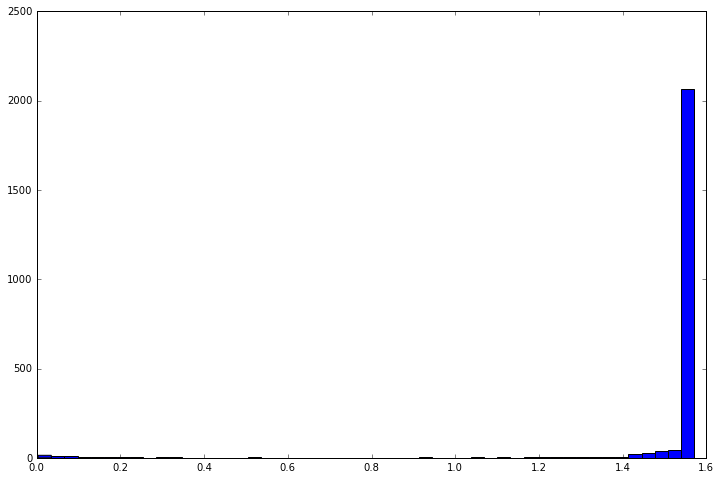

In [17]:
hist(angz[0,...].flatten(),50)
show()

In [18]:
usevec2 = np.logical_and(eigvecs[2,0,...] < 0.5, 
                         eigvals[1,...]/eigvals[0,...] < 1.5,
                        eigvecs[2,1,...] > 0.5)

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [19]:
print "Use eigvec 2 for {} ({:.0f}%) of vectors".format(np.sum(usevec2), float(np.sum(usevec2))/eigvecs[0,0,...].size * 100.0)

Use eigvec 2 for 6077 (15%) of vectors


In [20]:
angmax = 60 * np.pi/180

In [21]:
badangle = np.logical_and(angz > angmax, np.logical_not(usevec2))

In [22]:
print "{} ({:.0f}%) of vectors eliminated because of bad angles".format(np.sum(badangle),
                                                                    float(np.sum(badangle))/eigvecs[0,0,...].size * 100.0)

21148 (51%) of vectors eliminated because of bad angles


## Median filter

Look at the median vector in a neighborhood and eliminate vectors that are different by some angle

Neighborhood size (nbh x nbh x nbh)

In [23]:
nbh = 5
nbh2 = nbh / 2

In [24]:
eigvecsmed = np.zeros_like(eigvecs)

In [25]:
eigvecs2 = copy(eigvecs)
eigvecs2[:,0,badangle] = np.nan
eigvecs2[:,0,usevec2] = eigvecs2[:,2,usevec2]

In [26]:
with ProgressBar(total=np.prod([d-2*nbh2+1 for d in grid.shape[1:]])) as p:
    for i,j,k in itertools.product(np.arange(nbh2,eigvecs.shape[2]-nbh2),
                                  np.arange(nbh2,eigvecs.shape[3]-nbh2),
                                  np.arange(nbh2,eigvecs.shape[4]-nbh2)):
        #i,j,k = (22,50,100)
        nbhvec = eigvecs2[:, 0, i-nbh2:i+nbh2+1, j-nbh2:j+nbh2+1, k-nbh2:k+nbh2+1]
        nbhmed = [np.nanmedian(nbhvec[a,...]) for a in range(3)]
        if any(np.isfinite(nbhmed)):
            eigvecsmed[:,0,i,j,k] = nbhmed
        else:
            eigvecsmed[:,0,i,j,k] = np.nan
        p.update(1)

[----------------------------------------------------->       ] 88%  3sec elapsed, 0sec remaining


In [27]:
eigvecsmedlen = np.linalg.norm(eigvecsmed,axis=0, keepdims=True)

In [28]:
eigvecsmed = eigvecsmed / eigvecsmedlen

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [29]:
eigvecsmed[np.logical_not(isfinite(eigvecsmed))] = np.nan

## Save medians

In [30]:
if 'eigvecsmed' in datafile:
    del datafile['eigvecsmed']

In [31]:
d = datafile.create_dataset('eigvecsmed',data=eigvecsmed, chunks=True)
d.attrs['neighborhood'] = nbh

In [32]:
datafile.close()

## Load medians from file

In [33]:
datafile = h5.File(datafilename,'a')

In [34]:
eigvecsmed = np.array(datafile['eigvecsmed'])

In [35]:
dmedang1 = np.sum(eigvecs[:,0,...] * eigvecsmed[:,0,...], axis=0)
dmedang1[dmedang1 < 0.0] = -dmedang1[dmedang1 < 0.0]

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


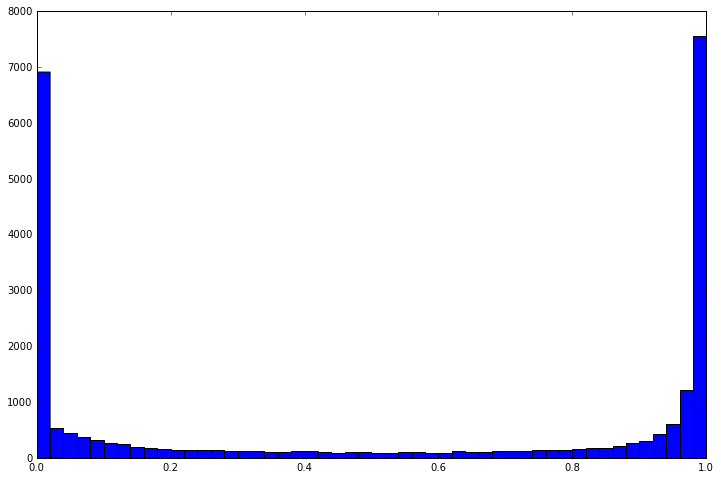

In [36]:
hist(dmedang1[np.isfinite(dmedang1)], bins=50)
show()

In [37]:
dmedang2 = np.sum(eigvecs[:,1,...] * eigvecsmed[:,0,...], axis=0)
dmedang2[dmedang2 < 0.0] = -dmedang2[dmedang2 < 0.0]

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [38]:
usevec2 = np.logical_and(dmedang1 < 0.5, dmedang2 > 0.5)

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [39]:
badmedian = np.logical_and(dmedang1 < 0.5, np.logical_not(usevec2))

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [40]:
print "{} ({:.0f}%) of vectors swapped with 2nd vector".format(
    np.sum(usevec2), float(np.sum(usevec2))/np.sum(np.isfinite(eigvecs2[0,0,...])) * 100.0)

print "{} ({:.0f}%) of vectors eliminated because of deviation from the median".format(
    np.sum(badmedian), float(np.sum(badmedian))/np.sum(np.isfinite(eigvecs2[0,0,...])) * 100.0)


3510 (17%) of vectors swapped with 2nd vector
7873 (39%) of vectors eliminated because of deviation from the median


In [41]:
eigvecsmooth = copy(eigvecs)
eigvecsmooth[:,0,badangle] = np.nan
eigvecsmooth[:,0,usevec2] = eigvecsmooth[:,1,usevec2]
eigvecsmooth[:,0,badmedian] = eigvecsmed[:,0,badmedian]

In [42]:
if 'eigvecsmooth' in datafile:
    del datafile['eigvecsmooth']
if 'badangle' in datafile:
    del datafile['badangle']
if 'usevec2' in datafile:
    del datafile['usevec2']
if 'badmedian' in datafile:
    del datafile['badmedian']

In [43]:
datafile.create_dataset('eigvecsmooth',data=eigvecsmooth, chunks=True)
datafile.create_dataset('badangle', data=badangle, chunks=True)
datafile.create_dataset('usevec2', data=usevec2, chunks=True)
datafile.create_dataset('badmedian', data=badmedian, chunks=True)

<HDF5 dataset "badmedian": shape (18, 35, 66), type "|b1">

In [44]:
datafile.close()

# Save as VTK

Load in from the HDF5 output file

In [47]:
datafilename = 'Drerio4-data2.h5'

In [48]:
datafile = h5.File(datafilename,'r')

In [49]:
grid = np.array(datafile['grid'])
intensity = np.array(datafile['means'])
eigvals = np.array(datafile['eigvals'])
eigvecs = np.array(datafile['eigvecs'])

In [50]:
vec1 = np.empty(3,dtype=object)
vec1[0] = eigvecs[0,0,...]
vec1[1] = eigvecs[1,0,...]
vec1[2] = eigvecs[2,0,...]

In [51]:
vecsm = np.empty(3,dtype=object)
vecsm[0] = eigvecsmooth[0,0,...]
vecsm[1] = eigvecsmooth[1,0,...]
vecsm[2] = eigvecsmooth[2,0,...]

In [53]:
angxz = np.arctan2(eigvecsmooth[0,0,...],eigvecsmooth[2,0,...])
angyz = np.arctan2(eigvecsmooth[1,0,...],eigvecsmooth[2,0,...])

In [54]:
vtkfile = 'Drerio4data.vts'

In [55]:
eigvals[eigvals==0] = np.nan
rc = -1.0/eigvals
rc[np.isnan(eigvals)] = 0.0

In [56]:
if os.path.exists(vtkfile):
    os.unlink(vtkfile)
write_structured_grid(vtkfile, grid, point_data=[("intensity", intensity), 
                                                 ("w1",rc[0,...]), ("w2",rc[1,...]), ("w3",rc[2,...]),
                                                 ("angxz",angxz),("angyz",angyz),
                                                 ("vec1",vec1),("vecsm",vecsm),
                                                 ("badang",badangle.astype(float)),("badmed",badmedian.astype(float))])

# Crop the CT images

In [69]:
imgdir = 'Drerio4_crop'
basename = 'Drerio4_crop_'

In [72]:
os.mkdir(imgdir)

In [70]:
inputdir = 'Drerio_4_recon'
files = glob.glob(os.path.join(inputdir,'Lewis_Drerio*.tif'))
files = files[0:-1]

In [71]:
crop = (slice(280,970),slice(80,-1))

In [74]:
with ProgressBar(total=len(files)) as p:
    for i,filename in enumerate(files):
        I1 = misc.imread(files[i])
        
        outname = os.path.join(imgdir,'{}{:04d}.tif'.format(basename,i))
        misc.imsave(outname, I1[crop])
        
        p.update(1)

[------------------------------------------------------------>] 100%  2m 53sec elapsed, 0sec remaining
